# GMM in PCA space of ensemble of reanalysis datasets

In [1]:
import os
from importlib import reload
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy as ctp
import seaborn as sns
from sklearn import mixture, decomposition

from latgmm.utils import utenso, preproc, eof, utdata, utstats, metric
import latgmm.geoplot as gpl

plt.style.use("../../paper.mplstyle")

## Load data

In [2]:
path = "../../data/cmip6/historical/CESM2"
normalization = 'zscore'

ensemble_list = []
for folder_name in os.listdir(path)[0:50]:
    full_path = os.path.join(path, folder_name)
    if os.path.isdir(full_path):
        print(f'Load data in folder: {folder_name}')
        forcing, inityear, member = folder_name.split("_")
        fname = os.path.join(full_path, f'b.e21.BHIST{forcing}.f09_g17.LE2-{inityear}.{member}.ssta_lat-31_33_lon130_290_gr1.0.nc')
        buff = xr.open_dataset(fname)
        buff = buff.assign_coords(member=('time', [folder_name]*len(buff.time)))
        ensemble_list.append(buff)
print("Merge members!")
ds = xr.concat(ensemble_list, dim='time')
ds['lon'] = preproc.get_antimeridian_coord(preproc.lon_to_180(ds['lon']))


# Normalization
if normalization is not None:
    print("Normalize data!")
    attributes = {}
    ds_norm = []
    for var in list(ds.data_vars):
        scaler = preproc.Normalizer(method=normalization)
        buff = scaler.fit_transform(ds[var])
        buff.attrs = {'normalizer': scaler}
        ds_norm.append(buff)

    ds = xr.merge(ds_norm) 


Load data in folder: smbb_1301_014
Load data in folder: cmip6_1281_005
Load data in folder: smbb_1231_017
Load data in folder: cmip6_1251_004
Load data in folder: cmip6_1181_010
Load data in folder: cmip6_1251_006
Load data in folder: cmip6_1251_007
Load data in folder: cmip6_1301_004
Load data in folder: smbb_1281_017
Load data in folder: smbb_1251_016
Load data in folder: smbb_1301_020
Load data in folder: smbb_1281_014
Load data in folder: cmip6_1281_004
Load data in folder: smbb_1071_004
Load data in folder: cmip6_1101_006
Load data in folder: smbb_1231_015
Load data in folder: cmip6_1231_003
Load data in folder: cmip6_1231_009
Load data in folder: smbb_1301_017
Load data in folder: smbb_1231_014
Load data in folder: cmip6_1301_009
Load data in folder: smbb_1281_019
Load data in folder: cmip6_1251_008
Load data in folder: smbb_1011_001
Load data in folder: cmip6_1251_005
Load data in folder: smbb_1251_018
Load data in folder: smbb_1301_012
Load data in folder: cmip6_1301_008
Load d

### EOF transformation

In [3]:
pcgmm_storer = {}
eof_projections = ["reanalysis", "CESM2", "CESM2 [10S,10N]"]
n_components = 2

# Load reanalysis data
datafile = "../../data/reanalysis/monthly/ssta_merged_dataset_1.nc"
ds_reanalysis = xr.open_dataset(datafile)
# Get common land sea mask from model
mask1 = ds['ssta'].isel(time=0).isnull()
mask2 = ds_reanalysis['ssta'].isel(time=0).isnull()
merged_mask = np.logical_or(mask1, mask2)

ds = ds.where(~merged_mask, other=np.nan)

for projection in eof_projections:
    print(f"Projection: {projection}")
    if projection == "reanalysis":
        ds4eof = ds_reanalysis.where(~merged_mask, other=np.nan)

        # Normalization
        if normalization is not None:
            attributes = {}
            ds_norm = []
            for var in list(ds4eof.data_vars):
                scaler = preproc.Normalizer(method=normalization)
                buff = scaler.fit_transform(ds4eof[var])
                buff.attrs = {'normalizer': scaler}
                ds_norm.append(buff)

            ds4eof = xr.merge(ds_norm) 
    elif projection == "CESM2":
        ds4eof = ds
    elif projection == "CESM2 [10S,10N]":
        ds4eof = ds.sel(lat=slice(-10,10))
    else:
        raise ValueError("Invalid projection")

    sppca = eof.SpatioTemporalPCA(ds4eof, n_components=n_components)
    print(f"Explained variance: {np.sum(sppca.explained_variance())}")
    if projection in ["CESM2", "CESM2 [10S,10N]"]:
        sppca.pca.components_[0,:] = -sppca.pca.components_[0,:]
    
    eofs = sppca.get_eofs()
    # Save EOFs and PCs
    pcgmm_storer[projection] = dict(
        sppca=sppca,
        eofs=eofs,
    )


Projection: reanalysis
Explained variance: 0.48587095571133615
Projection: CESM2
Explained variance: 0.6006383236203767
Projection: CESM2 [10S,10N]
Explained variance: 0.8109528047335309


### Project EOFs of CESM2 [-10, 10] to whole Pacific

In [4]:
pcs = pcgmm_storer['CESM2 [10S,10N]']['sppca'].get_principal_components()
e_pattern, _ = utstats.linear_regression_params(pcs.isel(eof=0), ds['ssta'])
c_pattern, _ = utstats.linear_regression_params(pcs.isel(eof=1), ds['ssta'])
# Replace zeros by Nans
e_pattern = e_pattern.where(e_pattern != 0.0, other=np.nan)
c_pattern = c_pattern.where(c_pattern != 0.0, other=np.nan)
# Merge and store
projected_eofs = xr.concat([e_pattern, c_pattern], dim='eof').to_dataset(name='ssta')
pcgmm_storer['regression coeff'] = dict(eofs=projected_eofs)
eof_projections.append("regression coeff")

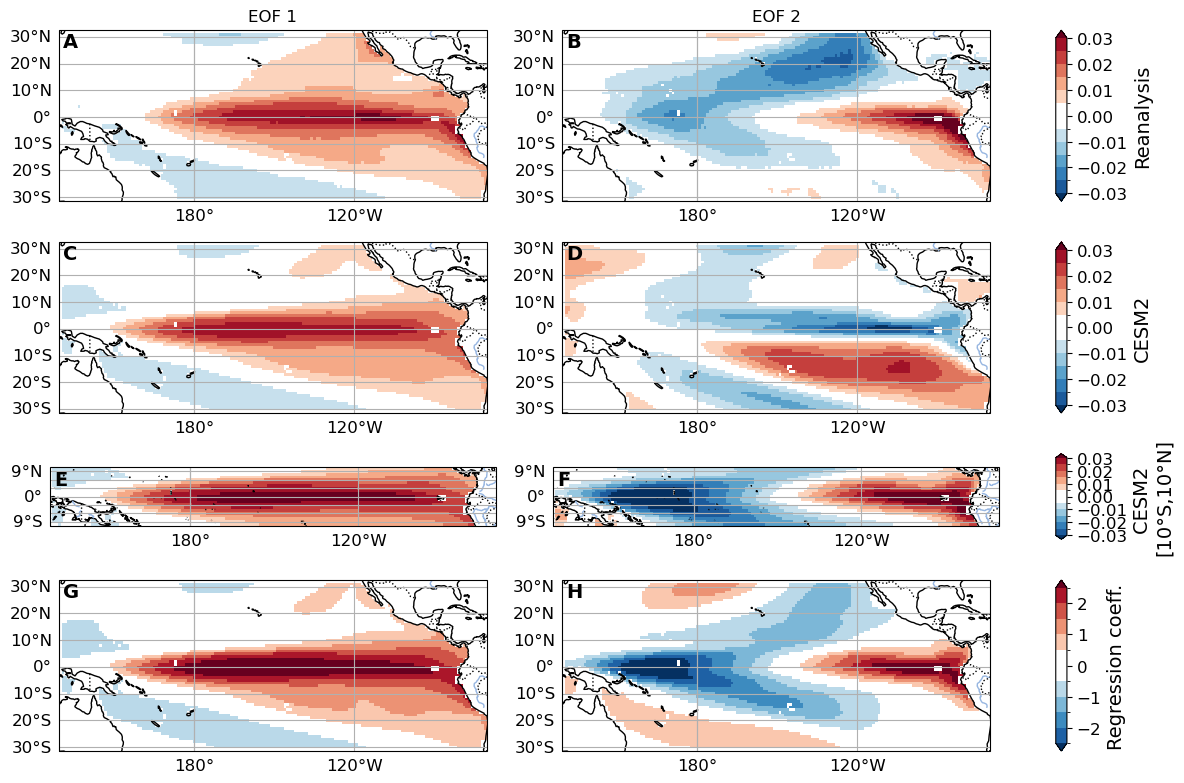

In [5]:
nrows = len(eof_projections)
ncols = n_components + 1

height_ratios = [2]*nrows
height_ratios[-2] = 1
width_ratios = [1]*ncols
width_ratios[-1] = 0.025

fig = plt.figure(figsize=(ncols*4, nrows*2.))
gs = gridspec.GridSpec(nrows, ncols, height_ratios=height_ratios, width_ratios=width_ratios)
proj = ctp.crs.PlateCarree(central_longitude=180)

labels = {
    "reanalysis": "Reanalysis",
    "CESM2": "CESM2",
    "CESM2 [10S,10N]": "CESM2 \n[10°S,10°N]",
    "regression coeff": "Regression coeff.",
}

axs = np.empty((nrows, ncols-1), dtype=object)
for i, projection in enumerate(eof_projections):
    storer = pcgmm_storer[projection]

    if projection == "regression coeff":
        plparam = dict(vmin=-2.5, vmax=2.5, step=0.5, cmap='RdBu_r', centercolor="#ffffff")
    else:
        plparam = dict(vmin=-0.03, vmax=0.03, step=0.005, cmap='RdBu_r', centercolor="#ffffff")

    # Plot EOFs
    for n in range(n_components):
        ax = fig.add_subplot(gs[i,n], projection=proj)
        eof_map =  storer['eofs'].isel(eof=n)
        if projection == "regression coeff":
            eof_map = eof_map/eof_map.std() 

        im = gpl.plot_map(eof_map['ssta'], central_longitude=180, ax=ax,
                          add_bar=False, **plparam)
        im['gl'].top_labels = False 

        if i == 0:
            ax.set_title(f"EOF {n+1}", fontsize=12)
    
        axs[i,n] = ax 


    cbar_ax = fig.add_subplot(gs[i,-1])
    cbar = plt.colorbar(im['im'], orientation='vertical', shrink=0.2,
                        cax=cbar_ax, extend='both')
    cbar.set_label(labels[projection], size=14)

# Enumerate plots
pos_y = 0.9 * np.ones((nrows, ncols-1))
pos_y[2,0], pos_y[2,1] = 0.7, 0.7
gpl.enumerate_subplots(axs.flatten(), pos_x=.01, pos_y=pos_y.flatten(), fontsize=14)
    
plt.savefig("../../output/plots/pcgmm_cesm2_compare_eofs.png", dpi=300, bbox_inches="tight")